# Tissue dielectric calculations
*Author: Dr Vitas Anderson*

Calculate tissue dielectric values using the Gabriel formulas published in:</br>
<font color='blue'>Gabriel, S. Lau, R.W. & Gabriel, C. (1996) **"The dielectric properties of biological tissues: III.
Parametric models for the dielectric spectrum of tissues"**, *Phys. Med. Biol.* 41 (1996) 2271–2293</font>

Tissue mass proportions were obtained from:</br>
<font color='blue'>Tahara, Y., Moji, K., Aoyagi, K., Tsunawake, N., Muraki, S., & Mascie-Taylor, C. G. N. (2002). **Age-related pattern of body density and body composition of Japanese men and women 18-59 years of age**. *American Journal of Human Biology*, 14(6).</font>

TARO intercomparison WBA SAR data was obtained from:</br>
<font color='blue'>Dimbylow, P. J., Hirata, A., & Nagaoka, T. (2008). **Intercomparison of whole-body averaged SAR in European and Japanese voxel phantoms**. Physics in Medicine and Biology, 53(20), 5883–5897.</font>

## Setup

In [1]:
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sn
from icecream import ic
import os
pd.set_option('display.max_rows', 100)

## Functions

In [2]:
def cce(w, e, tau, alpha):
    """Calculate the Cole-Cole equation for w (2.pi.f) and the dispersion parameters"""
    return e / (1 + (1j * w * tau)**(1-alpha))

def tissue_dielectric(p, fMHz, factor=1):
    """Calculate the Gabriel tissue dielectric values, er and sigma
       at fMHz frequency
       INPUTS:
         fMHz = frequency in MHz
         p = pandas array containing Gabriel tissue parameters
         factor = factor to multiply er and sigma (e.g. 2/3 for Hurt muscle)
       OUTPUTS:
         er = tissue relative permittivty
         sigma = tissue conductivity in units of S/m
       """
    
    # Permittivity of free space
    e0 = 8.85418782E-12  
    
    # Calculate the angular frequency, w'
    w = 2 * np.pi * (fMHz * 1e6)
    
    # Calculate the complex permitivity'
    ec = p.einf + cce(w,p.e1,p.tau1,p.alpha1) + \
                  cce(w,p.e2,p.tau2,p.alpha2) + \
                  cce(w,p.e3,p.tau3,p.alpha3) + \
                  cce(w,p.e4,p.tau4,p.alpha4) + \
                  p.sigma/(1j*w*e0)
    
    # Multiply ec by factor
    ec = ec * factor
    
    # Calculate permittivity and conductivity
    er = np.real(ec)
    sigma = -w * np.imag(ec) * e0
    
    return er, sigma

def make_quadfit(x,y):
    '''Returns a quadratic polynomial curve fitting function (quadfit)
       and the polynomial curvefit paramters (c) from 
       inputs arrays for x and y'''
    c = np.polyfit(x,y,2)
    quadfit = lambda x: c[0]*x**2 + c[1]*x + c[2]
    return quadfit, c

## Load tissue data

### Gabriel tissue dielectric parameters

In [3]:
gtdp = pd.read_excel("./data/Gabriel tissue dielectric parameters.xlsx",index_col=0).T.astype(float)
gtdp

TISSUE,einf,sigma,e1,tau1,alpha1,e2,tau2,alpha2,e3,tau3,alpha3,e4,tau4,alpha4
aorta,4.0,0.2500,40.0,8.842000e-12,0.10,50.0,3.183000e-09,0.10,100000.0,0.000159,0.20,10000000.0,0.001592,0.00
bladder,2.5,0.2000,16.0,8.842000e-12,0.10,400.0,1.592000e-07,0.10,100000.0,0.000159,0.20,10000000.0,0.015920,0.00
blood,4.0,0.7000,56.0,8.377000e-12,0.10,5200.0,1.326000e-07,0.10,0.0,0.000159,0.20,0.0,0.015920,0.00
bone cancellous,2.5,0.0700,18.0,1.326000e-11,0.22,300.0,7.958000e-08,0.25,20000.0,0.000159,0.20,20000000.0,0.015920,0.00
bone cortical,2.5,0.0200,10.0,1.326000e-11,0.20,180.0,7.958000e-08,0.20,5000.0,0.000159,0.20,100000.0,0.015920,0.00
bone marrow (infiltrated),2.5,0.1000,9.0,1.447000e-11,0.20,80.0,1.592000e-08,0.10,10000.0,0.001592,0.10,2000000.0,0.015920,0.10
bone marrow (not infiltrated),2.5,0.0005,3.0,7.958000e-12,0.20,25.0,1.592000e-08,0.10,5000.0,0.001592,0.10,2000000.0,0.015920,0.10
breast fat,2.5,0.0100,3.0,1.768000e-11,0.10,15.0,6.366000e-08,0.10,50000.0,0.000455,0.10,20000000.0,0.013260,0.00
cartilage,4.0,0.1500,38.0,1.326000e-11,0.15,2500.0,1.447000e-07,0.15,100000.0,0.000318,0.10,40000000.0,0.015920,0.00
cerebellum,4.0,0.0400,40.0,7.958000e-12,0.10,700.0,1.592000e-08,0.15,200000.0,0.000106,0.22,45000000.0,0.005305,0.00


### Taro model tissue masses

In [4]:
taro = pd.read_excel("./data/Taro tissue masses.xlsx","Gabriel category adjusted data",index_col=0)
taro_mass = taro.mass.sum().round(1)
taro['mass_prop'] = taro.mass / taro_mass
main_tissues = taro.index.to_list()
# ic(taro_mass,main_tissues)
display(taro)

,mass,mass_prop
tissue,,
muscle,26556.00,0.445221
fat (not infiltrated),14445.00,0.242176
bone cortical,8948.80,0.150030
bone cancellous,1789.76,0.030006
bone marrow (not infiltrated),447.44,0.007501
skin - dry,3722.00,0.062401
white matter,699.50,0.011727
grey matter,699.50,0.011727
liver,1185.00,0.019867


### Combine tissue dielectric and mass data 

In [5]:
gtdp_taro = gtdp.merge(taro,left_index=True,right_index=True,how='inner')
gtdp_taro

,einf,sigma,e1,tau1,alpha1,e2,tau2,alpha2,e3,tau3,alpha3,e4,tau4,alpha4,mass,mass_prop
bone cancellous,2.5,0.0700,18.0,1.326000e-11,0.22,300.0,7.958000e-08,0.25,20000.0,0.000159,0.20,20000000.0,0.015920,0.00,1789.76,0.030006
bone cortical,2.5,0.0200,10.0,1.326000e-11,0.20,180.0,7.958000e-08,0.20,5000.0,0.000159,0.20,100000.0,0.015920,0.00,8948.80,0.150030
bone marrow (not infiltrated),2.5,0.0005,3.0,7.958000e-12,0.20,25.0,1.592000e-08,0.10,5000.0,0.001592,0.10,2000000.0,0.015920,0.10,447.44,0.007501
fat (ave. infiltrated),2.5,0.0350,9.0,7.958000e-12,0.20,35.0,1.592000e-08,0.10,33000.0,0.000159,0.05,10000000.0,0.015920,0.01,69.60,0.001167
fat (not infiltrated),2.5,0.0100,3.0,7.958000e-12,0.20,15.0,1.592000e-08,0.10,33000.0,0.000159,0.05,10000000.0,0.007958,0.01,14445.00,0.242176
grey matter,4.0,0.0200,45.0,7.958000e-12,0.10,400.0,1.592000e-08,0.15,200000.0,0.000106,0.22,45000000.0,0.005305,0.00,699.50,0.011727
heart,4.0,0.0500,50.0,7.958000e-12,0.10,1200.0,1.592000e-07,0.05,450000.0,0.000072,0.22,25000000.0,0.004547,0.00,419.00,0.007025
kidney,4.0,0.0500,47.0,7.958000e-12,0.10,3500.0,1.989000e-07,0.22,250000.0,0.000080,0.22,30000000.0,0.004547,0.00,311.00,0.005214
liver,4.0,0.0200,39.0,8.842000e-12,0.10,6000.0,5.305000e-07,0.20,50000.0,0.000023,0.20,30000000.0,0.015920,0.05,1185.00,0.019867
muscle,4.0,0.2000,50.0,7.234000e-12,0.10,7000.0,3.537000e-07,0.10,1200000.0,0.000318,0.10,25000000.0,0.002274,0.00,26556.00,0.445221


### Calculate mass-weighted tissue dielectric values

In [6]:
# Set Dimbylow cross lab validation frequencies
freqs = [30, 40, 50, 60, 65, 70, 80, 90, 100, 120, 150, 180, 200, 300, 
         400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1500, 1800, 
         2000, 2450, 3000]

# Calculate tissue dielectric values by mass proportions
tlist = []
for fMHz in freqs:
    for t in gtdp_taro.itertuples():
        prop = t.mass_prop
        er, sigma = tissue_dielectric(t, fMHz)
        erp = er * prop
        sigmap = sigma * prop
        tlist.append([t.Index,fMHz,prop,er,erp,sigma,sigmap])

cols=('tissue','fMHz','prop','er','erp','sigma','sigmap')
diel = pd.DataFrame(tlist,columns=cols)
diel.to_clipboard()
print(*diel.tissue.unique(),sep=', ')

bone cancellous, bone cortical, bone marrow (not infiltrated), fat (ave. infiltrated), fat (not infiltrated), grey matter, heart, kidney, liver, muscle, skin - dry, spleen, stomach, thyroid, white matter


In [7]:
# Calculate total mass-weighted tissue dielectric values for Taro tissues
mask = diel.tissue.isin(taro.index)
dielmw = diel[mask].pivot_table(values=['erp','sigmap'],index=['fMHz'],aggfunc=sum).round(3)
dielmw.to_clipboard()

# Calculate dielectric values for 2/3 muscle
tt = []
for fMHz in freqs:
    er, sigma = tissue_dielectric(p=gtdp.loc['muscle'], fMHz=fMHz, factor=2/3)
    tt.append([fMHz,er,sigma])

muscle23 = pd.DataFrame(tt, columns=['fMHz','er 2/3 muscle','sigma 2/3 muscle']).round(3)
muscle23.set_index('fMHz',inplace=True)

dielmw.merge(muscle23,left_index=True,right_index=True)

,erp,sigmap,er 2/3 muscle,sigma 2/3 muscle
fMHz,,,,
30,64.843,0.362,61.207,0.439
40,57.143,0.372,55.050,0.446
50,52.517,0.379,51.375,0.452
60,49.426,0.386,48.923,0.457
65,48.235,0.388,47.979,0.459
70,47.212,0.391,47.168,0.461
80,45.545,0.396,45.846,0.465
90,44.243,0.400,44.812,0.469
100,43.197,0.404,43.981,0.472


### Quadratic curve fits for $\sigma(\epsilon_r)$

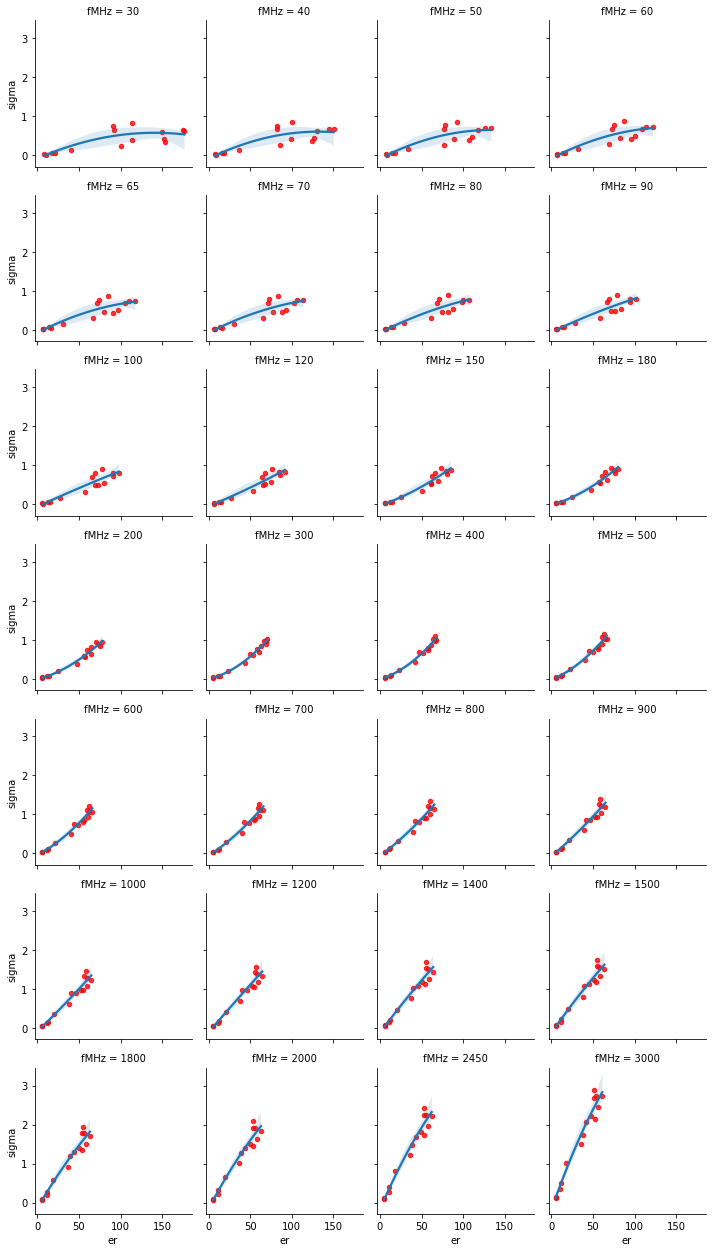

In [8]:
# plot curves for quadratic fit
mask = diel.tissue.isin(taro.index)
sn.lmplot(x="er",y="sigma",col='fMHz',col_wrap=4, 
          order=2, ci=95, height=2.5,scatter_kws={"s": 20,'color':'r'}, 
          data=diel[mask])
# plt.savefig('../plots/sigma v er per freq.png',dpi=200)

C:\Users\emeau\AppData\Local\Temp\ipykernel_15016\759414409.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfcoeffs = dfcoeffs.append(row,ignore_index=True)
C:\Users\emeau\AppData\Local\Temp\ipykernel_15016\759414409.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dielalpha = dielalpha.append(row,ignore_index=True)
C:\Users\emeau\AppData\Local\Temp\ipykernel_15016\759414409.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dielalpha = dielalpha.append(row,ignore_index=True)
C:\Users\emeau\AppData\Local\Temp\ipykernel_15016\759414409.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dielalpha = dielalpha.append(row,ignor

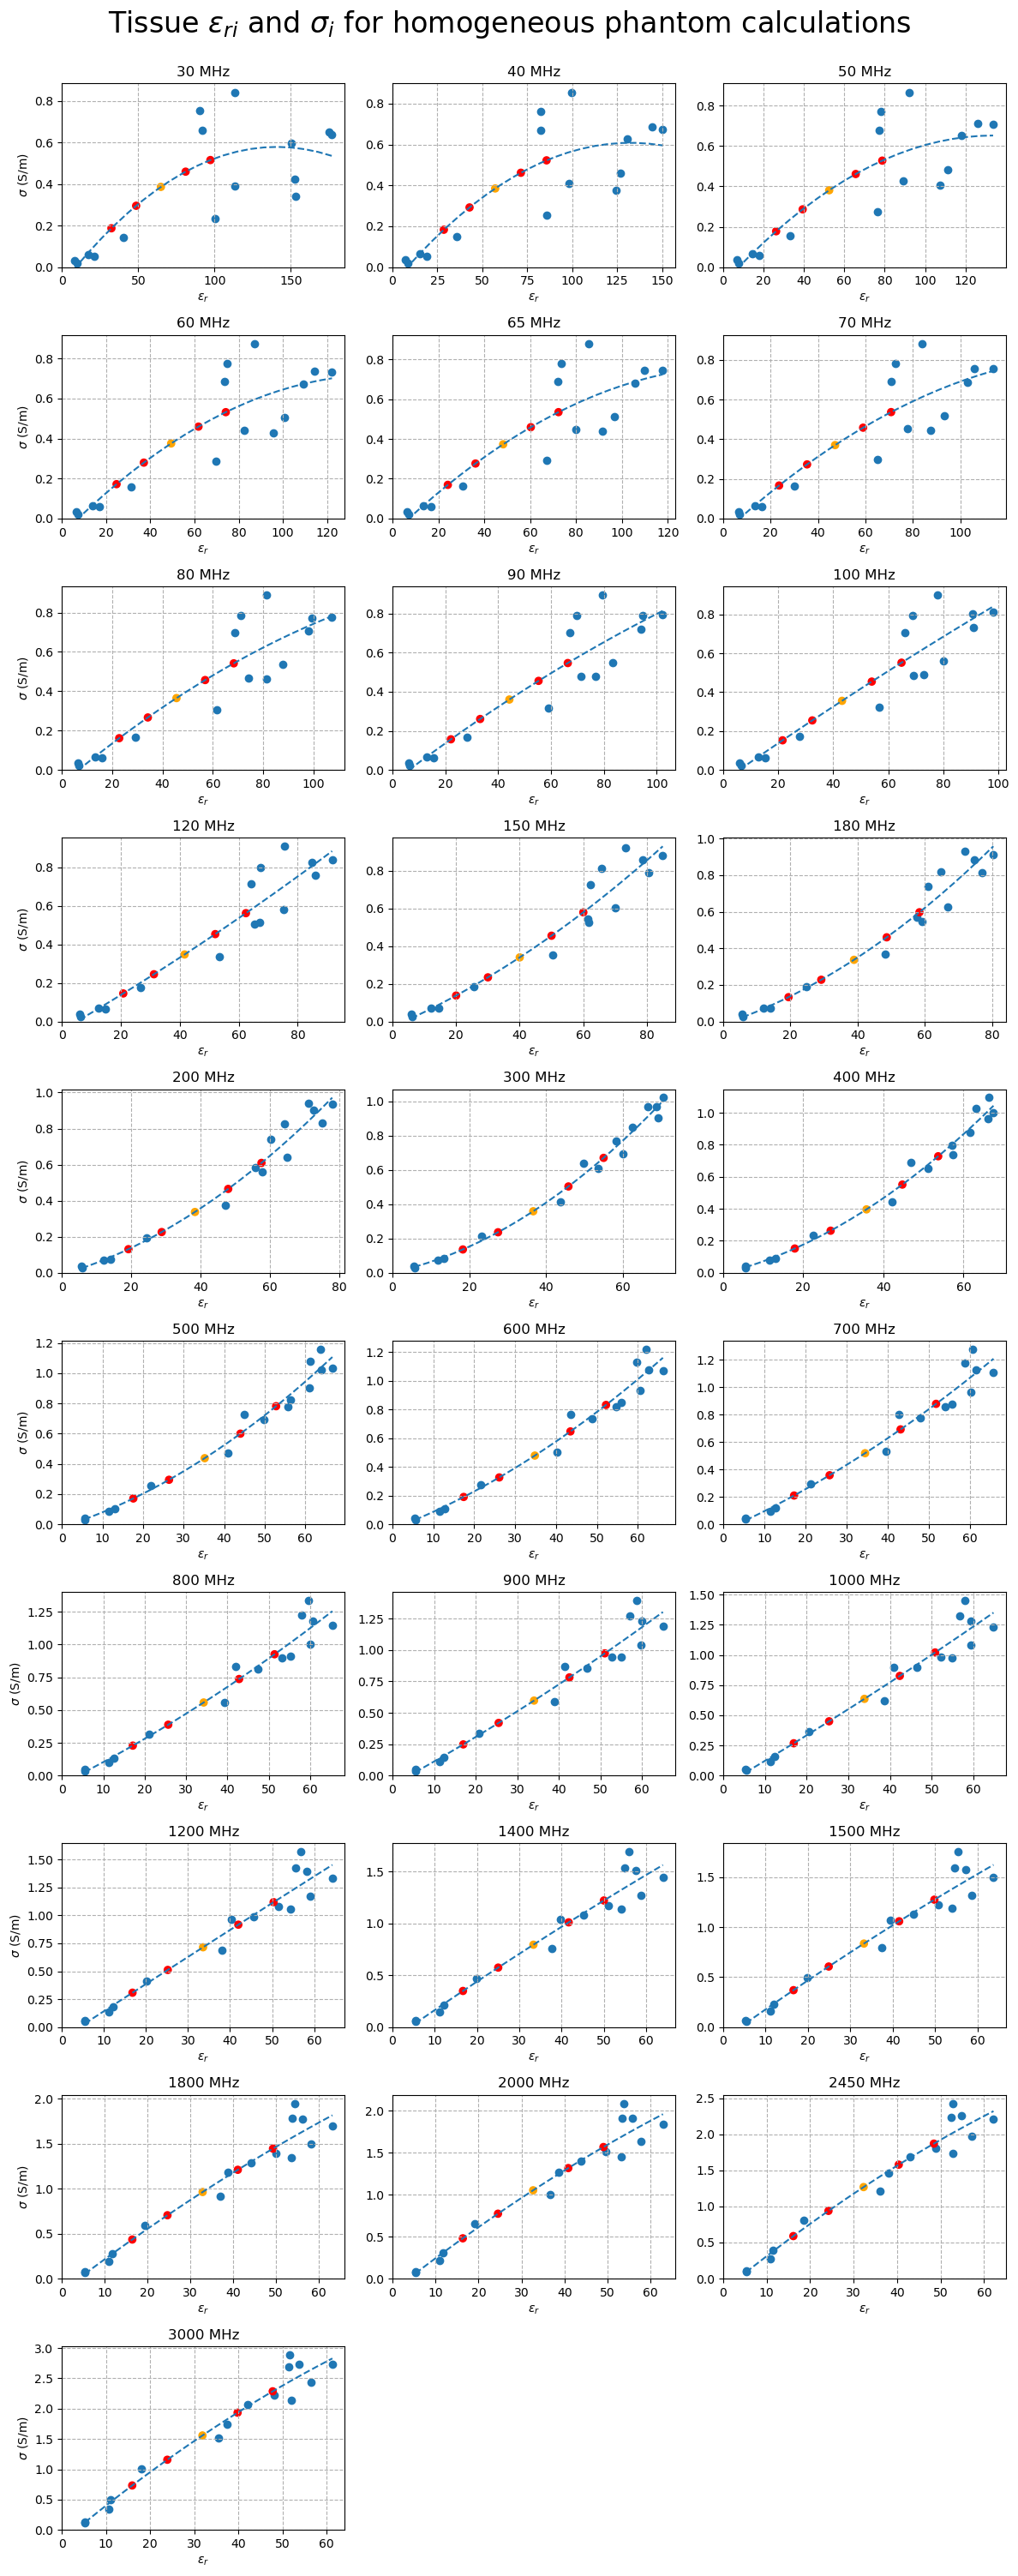

In [9]:
dalpha = 0.25  # delta alpha
# alpha = [1-2*dalpha, 1-dalpha, 1, 1+dalpha, 1+2*dalpha, 1+3*dalpha, 1+4*dalpha]
# alpha = [1-2*dalpha, 1+2*dalpha, 1+3*dalpha, 1+4*dalpha]
alpha = [1-2*dalpha, 1-dalpha, 1, 1+dalpha, 1+2*dalpha]
# colors = ['orange','r','r','r','orange','orange','orange']
# colors = ['orange','orange','orange','orange']
colors = ['r','r','orange','r','r']

fig, ax = plt.subplots(10,3,figsize=(12,30))
ax = ax.flatten()

quadfits = {}
dielalpha = pd.DataFrame(columns=('fMHz','alpha','er','sigma'))
dfcoeffs = pd.DataFrame(columns=('fMHz','c0','c1','c2'))
mask = diel.tissue.isin(taro.index)
for i, (f, g) in enumerate(diel[mask].groupby('fMHz')):
    # get Gabriel data for tissues at f MHz
    erf, sigf = g.er.values, g.sigma.values
    
    # create function to fit Gabriel sigma to quadratic polynomial in er 
    quadfit, c = make_quadfit(erf, sigf)
    quadfits[f] = quadfit
    row = {'fMHz':f,'c0':c[0],'c1':c[1],'c2':c[2]}
    dfcoeffs = dfcoeffs.append(row,ignore_index=True)
    
    # calculate points for quadratic fit function
    eri = np.linspace(erf.min(),erf.max(),20)
    sigi = quadfit(eri)
    
    # get mass weighted values for er and sigma
    erp, sigmap = dielmw.loc[f,['erp','sigmap']].values
    
    # calculate alpha points
    era = np.array([erp*a for a in alpha])
    siga = quadfit(era)
    for a, er, sig in zip(alpha,era,siga):
        row = {'fMHz':f,'alpha':a,'er':er,'sigma':sig}
        dielalpha = dielalpha.append(row,ignore_index=True)    
    
    #plot data
    ax[i].scatter(erf,sigf)
    ax[i].scatter(era,siga,color=colors)
    ax[i].plot(eri,sigi,'--')
    ax[i].set_title(f'{f} MHz')
    ax[i].set_xlim(left=0)
    ax[i].set_ylim(bottom=0)
    ax[i].grid(ls='--')
    ax[i].set_xlabel('$\epsilon_r$')
    if i % 3 == 0:
        ax[i].set_ylabel('$\sigma$ (S/m)')

ax[28].remove()
ax[29].remove()
title = 'Tissue $\epsilon_{ri}$ and $\sigma_i$ for homogeneous phantom calculations'
fig.suptitle(title,y=1,fontsize=24)
fig.tight_layout()
fig.savefig('../plots/er v sigma homog.png',dpi=300)

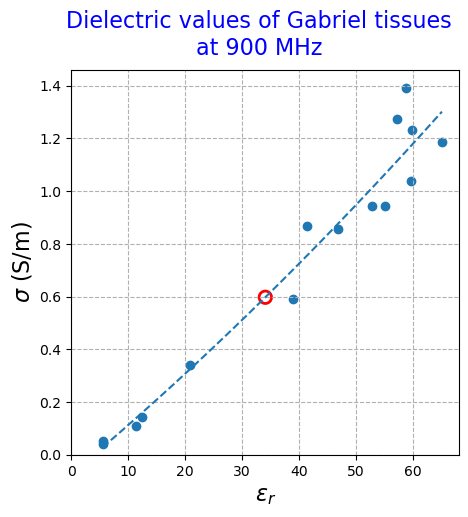

In [10]:
# Plot curve fit for 900 MHz and alpha=1
alpha = 1
f = 900

fig, ax = plt.subplots(1,1,figsize=(5,5))

# get Gabriel data for tissues at f MHz
mask = (diel.tissue.isin(taro.index)) & (diel.fMHz == f)
g = diel[mask]
erf, sigf = g.er.values, g.sigma.values

# create function to fit Gabriel sigma to quadratic polynomial in er 
quadfit, c = make_quadfit(erf, sigf)

# calculate points for quadratic fit function
eri = np.linspace(erf.min(),erf.max(),20)
sigi = quadfit(eri)

# get mass weighted values for er and sigma
erp, sigmap = dielmw.loc[f,['erp','sigmap']].values
era = erp
siga = quadfit(erp)

#plot data
ax.scatter(erf,sigf)
ax.scatter(era,siga,color="none", edgecolor="red",s=80,lw=2)
ax.plot(eri,sigi,'--')
# ax.set_title(f'{f} MHz',fontsize=16)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.grid(ls='--')
ax.set_xlabel('$\epsilon_r$',fontsize=16)
ax.set_ylabel('$\sigma$ (S/m)',fontsize=16)
title = 'Dielectric values of Gabriel tissues\nat 900 MHz'
fig.suptitle(title,y=1,fontsize=16,color='blue')
# fig.tight_layout()
fig.savefig('../plots/er v sigma homog 900.png',dpi=300)

In [11]:
dielalpha.to_excel('./data/er and sigma for homogeneous phantom trials_4.xlsx')
dielalpha

,fMHz,alpha,er,sigma
0,30.0,0.5,32.4215,0.187227
1,30.0,0.75,48.63225,0.295703
2,30.0,1.0,64.843,0.386648
3,30.0,1.25,81.05375,0.460064
4,30.0,1.5,97.2645,0.515949
...,...,...,...,...
135,3000.0,0.5,15.9165,0.734226
136,3000.0,0.75,23.87475,1.15858
137,3000.0,1.0,31.833,1.55879
138,3000.0,1.25,39.79125,1.934853


## Create plots of tissue dielectric parameters

### Create dataframe of $\epsilon_r$ and $\sigma$ for all tissues and selected frequencies

In [12]:
freqs2 = [100,200,400,1000,2000,5000]

tt = []
for fMHz in freqs2:
    for row in gtdp.itertuples():
        er, sigma = tissue_dielectric(row, fMHz=fMHz)
        tt.append([row.Index,fMHz,er,sigma])

df = pd.DataFrame(tt, columns=['tissue','fMHz','er','sigma']).round(3)

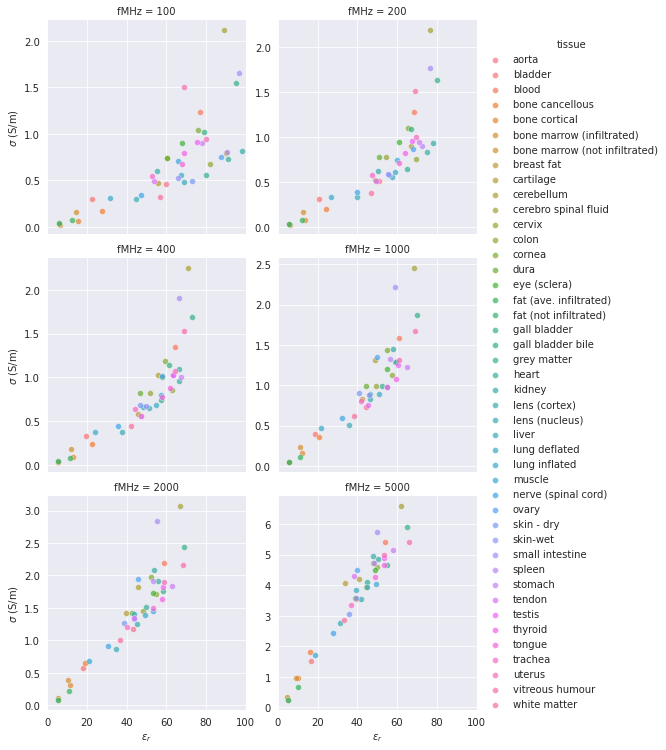

In [13]:
with sn.axes_style("darkgrid"):
    g = sn.FacetGrid(df, col="fMHz", col_wrap=2, height=3.5,
                     hue="tissue",xlim=(0,100),sharey=False)
    g.map(sn.scatterplot, "er", "sigma", alpha=.7)
    g.add_legend()
    g.set_axis_labels(r'$\epsilon_r$',r'$\sigma$ (S/m)')
    g.tight_layout()
    g.savefig('../plots/sigma v er.png',dpi=200)

## Calculate WBA SAR dielectric tissue properties

### Load WBA SAR data (µW/kg) from TARO intercomparison study and Danie's FEKO SEP phantom

In [ ]:
taro_file = "./data/TARO and HANAKO intercomparison data.xlsx"
taroSAR = pd.read_excel(taro_file, 'TARO',usecols=['MHz','HPA'])
taroSAR.rename(columns={'MHz':'fMHz','HPA':'SARtaro'},inplace=True)

FEKO_SEP_file = './data/results_human-phantom-height1.72-vol6.07353E-2.csv'
sepSAR = pd.read_csv(FEKO_SEP_file)
sepSAR.columns = ['fMHz','alpha','er','sigma','P','SARsep']
sepSAR.SARsep = sepSAR.SARsep * 1E6

dfSAR = sepSAR.merge(taroSAR,on='fMHz')
dfSAR['SARratio'] = dfSAR.SARsep / dfSAR.SARtaro
dfSAR

### Load data directly from .out files

In [13]:
# Get .out files
# folder = 'C:/Users/emeau/Dropbox/Spat avg WG/Data/MBS panel antenna/SAR outputs/TARO-plane-wave-comparison/900MHz-results/'
folder = 'D:/Dropbox/Spat avg WG/Data/MBS panel antenna/SAR outputs/TARO-plane-wave-comparison/constant_volume_30MHz_to_1.2GHz/out_files/'
files = os.listdir(folder)
files = [file for file in files if '.out' in file]

# Parse files for output data
data_out = []
for file in files:
    alpha = float(file[-8:-4])
    file = folder + file
    with open(file) as f:
        lines = f.readlines()
    for line in lines:
        data = line.split()
        if len(data) == 0:
            pass
        elif data[-1] == 'human':
            er = float(data[-9])
            sigma = float(data[-7])
            density = float(data[-3])
            vol = float(data[-2])
        elif 'FREQ =' in line:
            fMHz = float(data[-1]) / 1E6
        elif data[0] == 'Dielectric:':
            power = float(data[1])
            break
    data_out.append([fMHz,alpha,er,sigma,power,density,vol])        
            
fileSAR = pd.DataFrame(data_out, columns=['fMHz','alpha','er','sigma','P','density','vol'])
fileSAR = fileSAR.sort_values(['fMHz','alpha'])
fileSAR['SARsep'] = (fileSAR.P / (fileSAR.vol * 1000) * 1E6).round(3)

dfSAR2 = fileSAR.merge(taroSAR[taroSAR.fMHz<=1200],on='fMHz')
dfSAR2['SARratio'] = dfSAR2.SARsep / dfSAR2.SARtaro
dfSAR2

,fMHz,alpha,er,sigma,P,density,vol,SARsep,SARtaro,SARratio
0,30.0,0.50,32.42150,0.187227,0.001427,1000.0,0.060736,23.500,15.96,1.472431
1,30.0,0.75,48.63225,0.295703,0.001179,1000.0,0.060736,19.415,15.96,1.216479
2,30.0,1.00,64.84300,0.386648,0.001002,1000.0,0.060736,16.504,15.96,1.034085
3,30.0,1.25,81.05375,0.460064,0.000886,1000.0,0.060736,14.583,15.96,0.913722
4,30.0,1.50,97.26450,0.515949,0.000807,1000.0,0.060736,13.287,15.96,0.832519
...,...,...,...,...,...,...,...,...,...,...
105,1200.0,0.50,16.78600,0.308121,0.001348,1000.0,0.060736,22.191,20.34,1.091003
106,1200.0,0.75,25.17900,0.511751,0.001222,1000.0,0.060736,20.120,20.34,0.989184
107,1200.0,1.00,33.57200,0.714630,0.001115,1000.0,0.060736,18.365,20.34,0.902901
108,1200.0,1.25,41.96500,0.916757,0.001033,1000.0,0.060736,17.005,20.34,0.836037


In [ ]:
dfSAR2.to_excel('../

### Plot the data

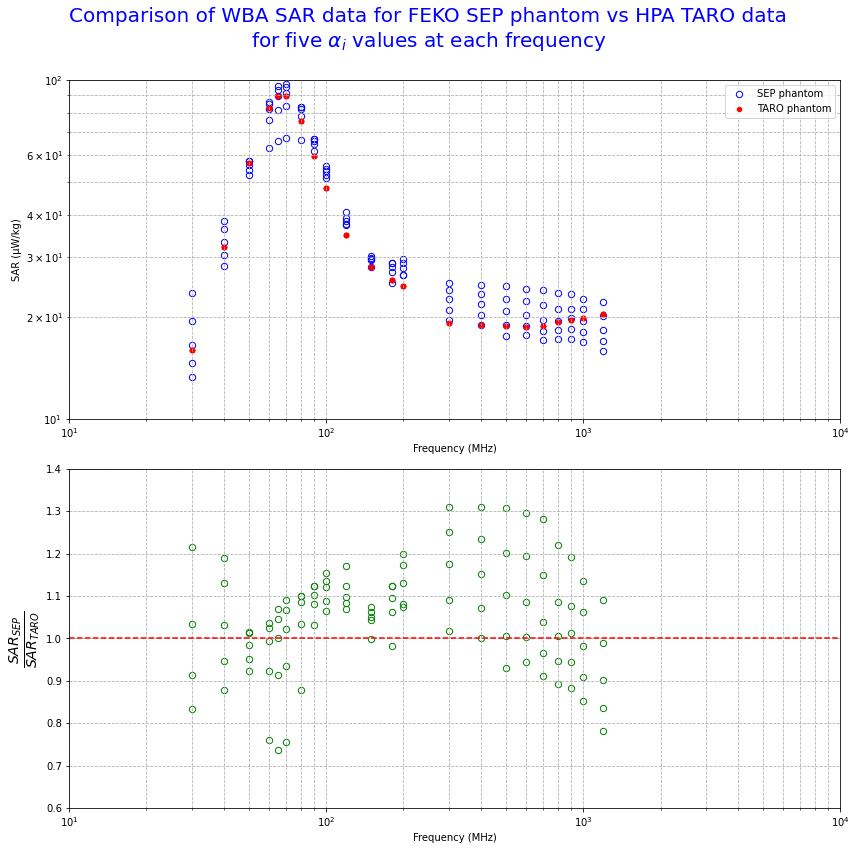

In [18]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(12,12))
plt.suptitle('Comparison of WBA SAR data for FEKO SEP phantom vs HPA TARO data\nfor five $\\alpha_i$ values at each frequency',
             color='blue',fontsize=20)

# top plot
dfSAR2.plot(x='fMHz',y='SARsep',kind='scatter',color="none", edgecolor="blue",s=40,
           ax=ax1,label='SEP phantom')
dfSAR2.plot(x='fMHz',y='SARtaro',kind='scatter',color='r',
           ax=ax1, label='TARO phantom')
ax1.set_ylim([10,100])
ax1.set_xlim([10,10_000])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Frequency (MHz)')
ax1.set_ylabel('SAR (µW/kg)')
ax1.legend()
ax1.grid(True, which='both',ls='--')

# bottom plot
dfSAR2.plot(x='fMHz',y='SARratio',kind='scatter',color="none", 
            edgecolor="green",s=40, ax=ax2)
ax2.axhline(y=1, color='r', linestyle='--')
ax2.set_ylim([0.6,1.4])
ax2.set_xlim([10,10_000])
ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{SAR_{SEP}}{SAR_{TARO}}$', fontsize=20)
ax2.set_xlabel('Frequency (MHz)')
ax2.grid(True, which='both',ls='--')
fig.tight_layout(rect=(0,0,1,0.98))

# Save the figure
fig.savefig('../plots/FEKO SEP vs HPA WBA SAR.png');


### Calculate $\alpha$ to match sepSAR to taroSAR 

C:\Users\emeau\anaconda3\envs\py39\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


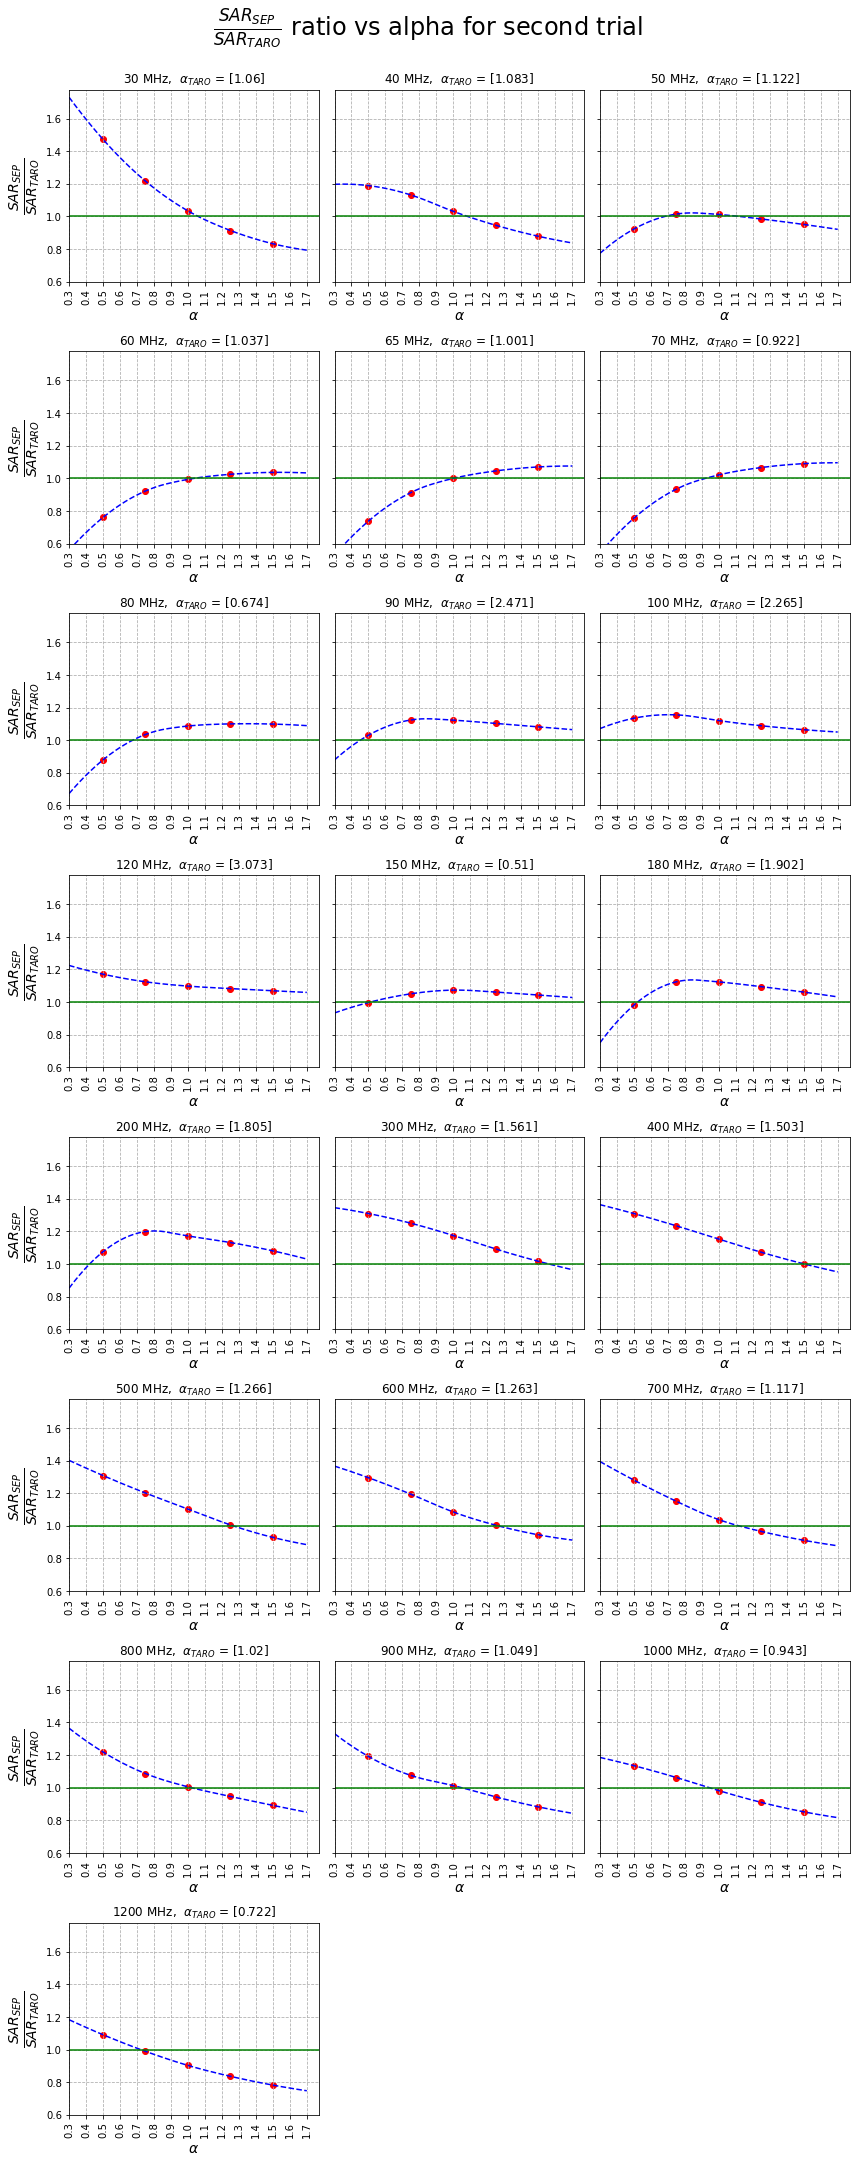

In [19]:
fig,ax = plt.subplots(8,3,figsize=(12,30),sharey=True)
ax = ax.flatten()

for i, (fMHz, g) in enumerate(dfSAR2.groupby('fMHz')):
    fMHz = int(fMHz)
    alpha = g.alpha.values
    SARratio = g.SARratio.values
    alpha_lower = alpha[0] - 0.2
    alpha_upper = alpha[-1] + 0.2
    f = interpolate.interp1d(alpha, SARratio, kind='quadratic',
                             fill_value='extrapolate')
    alphai = np.arange(alpha_lower, alpha_upper+0.01, 0.01)
    SARratioi = f(alphai)
    
    froot = lambda x: f(x) - 1
    alpharoot = fsolve(froot,1).round(3)

    ax[i].scatter(alpha,SARratio,color='red')
    ax[i].plot(alphai,SARratioi,'--',color='blue')
    ax[i].axhline(y=1,color='green',ls='-')
    ax[i].set_title(f'{fMHz} MHz, ' + r' $\alpha_{TARO}$ = ' + f'{alpharoot}')
    ax[i].set_xlim(left=alpha_lower)
    ax[i].set_xticks(np.arange(alpha_lower, alpha_upper+0.1, 0.1))
    ax[i].set_xticklabels(ax[i].get_xticks().round(1), rotation=90)
    ax[i].set_ylim(bottom=0.6)
    ax[i].grid(ls='--')
    ax[i].set_xlabel(r'$\alpha$', fontsize=14)
    if i % 3 == 0:
        ax[i].set_ylabel(r'$\frac{SAR_{SEP}}{SAR_{TARO}}$', fontsize=20)

ax[22].remove()
ax[23].remove()
title = r'$\frac{SAR_{SEP}}{SAR_{TARO}}$ ratio vs alpha for second trial'
fig.suptitle(title,y=1,fontsize=24)
fig.tight_layout()
fig.savefig('../plots/alpha v SAR')

In [39]:
def fn(g):
    alpha = g.alpha.values
    er0 = g.er[g.alpha == 1].values[0]
    SARsep = g.SARsep.values.round(2)
    SARtaro=g.SARtaro.values[0]
    SARratio = g.SARratio.values
    f = interpolate.interp1d(alpha, SARratio, kind='quadratic',
                             fill_value='extrapolate')   
    froot = lambda x: f(x) - 1
    alpharoot = fsolve(froot,1)[0]
    
    row = dict(SARsep=SARsep,
               alpha=alpha,
               SARtaro=SARtaro,
               alphafit=round(alpharoot,4),
               erfit=er0*alpharoot,
               sigmafit=quadfits[g.name](er0*alpharoot))
    return pd.Series(row)
    
dfalpha = dfSAR2.groupby('fMHz').apply(fn)
dfalpha.index.name = 'fMHZ'
dfalpha.to_excel('./data/alpha trial data.xlsx')
dfalpha.head(50)

,SARsep,alpha,SARtaro,alphafit,erfit,sigmafit
fMHZ,,,,,,
30.0,"[23.5, 19.42, 16.5, 14.58, 13.29]","[0.5, 0.75, 1.0, 1.25, 1.5]",15.96,1.0604,68.757374,0.405981
40.0,"[38.28, 36.43, 33.2, 30.44, 28.28]","[0.5, 0.75, 1.0, 1.25, 1.5]",32.20,1.0834,61.906614,0.412570
50.0,"[52.54, 57.76, 57.63, 56.04, 54.13]","[0.5, 0.75, 1.0, 1.25, 1.5]",56.93,1.1218,58.911469,0.421801
60.0,"[62.93, 76.35, 82.24, 84.83, 85.79]","[0.5, 0.75, 1.0, 1.25, 1.5]",82.78,1.0371,51.260061,0.388986
65.0,"[65.98, 81.65, 89.42, 93.51, 95.69]","[0.5, 0.75, 1.0, 1.25, 1.5]",89.44,1.0008,48.274469,0.373404
...,...,...,...,...,...,...
700.0,"[24.08, 21.64, 19.52, 18.16, 17.14]","[0.5, 0.75, 1.0, 1.25, 1.5]",18.81,1.1172,38.551704,0.598329
800.0,"[23.6, 21.04, 19.46, 18.32, 17.26]","[0.5, 0.75, 1.0, 1.25, 1.5]",19.36,1.0203,34.955847,0.572304
900.0,"[23.32, 21.04, 19.82, 18.46, 17.27]","[0.5, 0.75, 1.0, 1.25, 1.5]",19.57,1.0488,35.714055,0.632729


### Check volumes in .out files of first alpha trials

In [41]:
files

[]

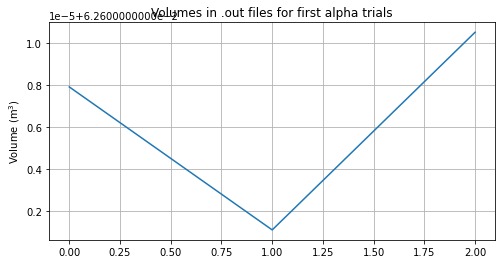

In [42]:
# Get list of .out files
# folder = 'C:/Users/emeau/Dropbox/Spat avg WG/Data/MBS panel antenna/SAR outputs/TARO-plane-wave-comparison/900MHz-results/'
folder = 'D:/Dropbox/Spat avg WG/Data/MBS panel antenna/SAR outputs/TARO-plane-wave-comparison/900MHz-results/_old/'
files = os.listdir(folder)
files = [file for file in files if '.out' in file]

filevol = []
for file in files:
    file = folder + file
    with open(file) as f:
        lines = f.readlines()
    for line in lines:
        if 'human\n' in line:
            vol = line.split()[-2]
            filevol.append([file, float(vol)])
            break

filevoldf = pd.DataFrame(filevol, columns=('file','volume'))
# sn.relplot(y='volume',kind='line',data=filevoldf)
fig,ax = plt.subplots(figsize=(8,4))
filevoldf.volume.plot(ax=ax)
ax.grid()
ax.set_ylabel("Volume (m$^3$)")
ax.set_title('Volumes in .out files for first alpha trials')
fig.savefig('../plots/phantom volumes of 1st alpha trials.png')

## 3D skewed grid for MBS antenna trial

In [74]:
x = [-0.8, -0.3, 0.2, 0.5, 0.8, 1.3, 2, 3.2, 5, 7.3, 10, 13]
y = [0, 0.3, 0.8, 1.6, 2.6, 4, 6]
z = [-2, -1, 0, 1, 2]
points = [[xi,yi,zi] for xi in x for yi in y for zi in z]
pointsdf = pd.DataFrame(points,columns=['x','y','z'])
pointsdf.to_csv('./data/skewed 3d grid for MBS panel.csv',index=False)

## Scratch

### Create log scale of investigation frequencies

In [47]:
freqs = np.logspace(2,np.log10(6000),num=21).round(1)
print(*freqs, sep=', ')

100.0, 122.7, 150.6, 184.8, 226.8, 278.3, 341.5, 419.1, 514.4, 631.2, 774.6, 950.6, 1166.5, 1431.5, 1756.7, 2155.8, 2645.6, 3246.6, 3984.2, 4889.3, 6000.0


### test out the cce function

In [49]:
fMHz = 100
tissue = 'aorta'

print(tissue)
w = 2 * np.pi * fMHz * 1e6
for i in [1,2,3,4]:
    e, tau, alpha = gtdp.loc[tissue,"e"+str(i):"alpha"+str(i)]
    print(f'{i}: {w=}, {e=}, {tau=}, {alpha=}')
    disp = cce(w,e,tau,alpha) 
    print(f'{disp=}\n')

aorta
1: w=628318530.7179587, e=40.0, tau=8.842e-12, alpha=0.1
disp=(39.93826589119501-0.3678176108102568j)

2: w=628318530.7179587, e=50.0, tau=3.183e-09, alpha=0.1
disp=(12.751218109509889-18.190916334023942j)

3: w=628318530.7179587, e=100000.0, tau=0.0001592, alpha=0.2
disp=(3.090278827925935-9.507824174111935j)

4: w=628318530.7179587, e=10000000.0, tau=0.001592, alpha=0.0
disp=(9.994340385406586e-06-9.997169792194487j)

